## Remove unused columns, rows with missing info, etc.

In [1]:
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# path to cloned https://github.com/jump-cellpainting/datasets
ORF_METADATA_PATH = Path("../../datasets/metadata") / "orf.csv.gz"
WELL_METADATA_PATH = Path("../../datasets/metadata") / "well.csv.gz"

# path to cloned https://github.com/jump-cellpainting/jump-orf-data
PLATEMAP_FILES = Path("../../jump-orf-data/metadata/platemaps").glob("*/*.csv")
PLATEMAP_COLS = ["Metadata_Plate", "Metadata_plate_map_name"]

# path to cloned morphmap repo https://github.com/jump-cellpainting/morphmap
CELL_COUNTS_PATH = Path("../../morphmap") / "0.explore-data/output/cell_counts.csv.gz"

ORF_MERGE_WELL_COLS = ["Metadata_JCP2022"]
METADATA_MERGE_PLATEMAPS_COLS = ["Metadata_Plate"]
METADATA_MERGE_CELLCOUNTS_COLS = [
    "Metadata_plate_map_name",
    "Metadata_Well",
    "Metadata_Plate",
    "Metadata_broad_sample",
]
METADATA_MERGE_PROFILES_COLS = ["Metadata_Plate", "Metadata_Well", "Metadata_Source"]

RAW_PROFILES_PATH = Path("input/raw_profiles.parquet")
RENAME_COLS_RAW = {"dataset": "Metadata_Batch"}
DROP_COLS_RAW = ['source', 'workspace', 'profiles', 'batch', 'plate']

#### Read metadata

In [3]:
orf = pd.read_csv(ORF_METADATA_PATH)
wells = pd.read_csv(WELL_METADATA_PATH)
cell_counts = pd.read_csv(CELL_COUNTS_PATH)
platemaps = pd.concat((pd.read_csv(f) for f in PLATEMAP_FILES), ignore_index=True)
platemaps.columns = PLATEMAP_COLS

#### Merge metadata

In [4]:
metadata = orf.merge(wells, on=ORF_MERGE_WELL_COLS).merge(platemaps, on=METADATA_MERGE_PLATEMAPS_COLS)
metadata

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_plate_map_name
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt,source_4,BR00125170,E18,OAB09.10.11.12.A
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,795.0,trt,source_4,BR00125170,B09,OAB09.10.11.12.A
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,1212.0,trt,source_4,BR00125170,K03,OAB09.10.11.12.A
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,963.0,trt,source_4,BR00125170,H11,OAB09.10.11.12.A
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,795.0,trt,source_4,BR00125170,B17,OAB09.10.11.12.A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86694,JCP2022_915132,ccsbBroad304_99997,ORFC00005.1_TRC304.1,pLX_304,eGFP.1,eGFP,eGFP,CONTROL,Hahn Lab eGFP,100.0,717.0,poscon,source_4,BR00126714,O20,OKA01.02.03.04.A
86695,JCP2022_915132,ccsbBroad304_99997,ORFC00005.1_TRC304.1,pLX_304,eGFP.1,eGFP,eGFP,CONTROL,Hahn Lab eGFP,100.0,717.0,poscon,source_4,BR00126714,P17,OKA01.02.03.04.A
86696,JCP2022_915132,ccsbBroad304_99997,ORFC00005.1_TRC304.1,pLX_304,eGFP.1,eGFP,eGFP,CONTROL,Hahn Lab eGFP,100.0,717.0,poscon,source_4,BR00126714,P18,OKA01.02.03.04.A
86697,JCP2022_915132,ccsbBroad304_99997,ORFC00005.1_TRC304.1,pLX_304,eGFP.1,eGFP,eGFP,CONTROL,Hahn Lab eGFP,100.0,717.0,poscon,source_4,BR00126714,P19,OKA01.02.03.04.A


#### Plates missing from cell counts, but present in metadata (none vice versa)

In [5]:
missing_plates = metadata.Metadata_Plate[~metadata.Metadata_Plate.isin(cell_counts.Metadata_Plate)].unique()
missing_plates

array(['BR00126708', 'BR00126712', 'BR00126715', 'BR00126716',
       'BR00126717', 'BR00126718', 'BR00123528A', 'BR00126706',
       'BR00126709', 'BR00126710', 'BR00126711', 'BR00126714'],
      dtype=object)

#### Remove plates with missing cell counts (whole of Batch 12 & one plate BR00123528A from Batch 2)

In [6]:
metadata = metadata[~metadata.Metadata_Plate.isin(missing_plates)]

#### Merge cell counts

In [7]:
metadata = metadata.merge(cell_counts, on=METADATA_MERGE_CELLCOUNTS_COLS, how="left")
metadata

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_plate_map_name,Metadata_Count_Cells
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt,source_4,BR00125170,E18,OAB09.10.11.12.A,1088
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,795.0,trt,source_4,BR00125170,B09,OAB09.10.11.12.A,1180
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,1212.0,trt,source_4,BR00125170,K03,OAB09.10.11.12.A,1107
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,963.0,trt,source_4,BR00125170,H11,OAB09.10.11.12.A,1144
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,795.0,trt,source_4,BR00125170,B17,OAB09.10.11.12.A,1106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82278,JCP2022_915132,ccsbBroad304_99997,ORFC00005.1_TRC304.1,pLX_304,eGFP.1,eGFP,eGFP,CONTROL,Hahn Lab eGFP,100.0,717.0,poscon,source_4,BR00126543,O20,OKA01.02.03.04.A,1152
82279,JCP2022_915132,ccsbBroad304_99997,ORFC00005.1_TRC304.1,pLX_304,eGFP.1,eGFP,eGFP,CONTROL,Hahn Lab eGFP,100.0,717.0,poscon,source_4,BR00126543,P17,OKA01.02.03.04.A,1269
82280,JCP2022_915132,ccsbBroad304_99997,ORFC00005.1_TRC304.1,pLX_304,eGFP.1,eGFP,eGFP,CONTROL,Hahn Lab eGFP,100.0,717.0,poscon,source_4,BR00126543,P18,OKA01.02.03.04.A,1377
82281,JCP2022_915132,ccsbBroad304_99997,ORFC00005.1_TRC304.1,pLX_304,eGFP.1,eGFP,eGFP,CONTROL,Hahn Lab eGFP,100.0,717.0,poscon,source_4,BR00126543,P19,OKA01.02.03.04.A,1208


#### Read profiles

In [8]:
profiles = pd.read_parquet(RAW_PROFILES_PATH)
profiles

,Metadata_Source,Metadata_Plate,Metadata_Well,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_Center_X,...,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,dataset,source,workspace,profiles,batch,plate
0,source_4,BR00117035,A01,5834.000000,12214.000000,569.679993,552.330017,460.510010,444.850006,515.229980,...,34.516998,35.355000,34.396000,35.499001,2021_04_26_Batch1,BR00117035,None,None,None,None
1,source_4,BR00117035,A02,5463.799805,11298.000000,573.630005,521.140015,469.579987,416.619995,521.219971,...,41.456001,42.639999,41.368000,42.675999,2021_04_26_Batch1,BR00117035,None,None,None,None
2,source_4,BR00117035,A03,5416.000000,10838.000000,602.969971,526.530029,501.630005,423.839996,551.570007,...,43.127998,44.056000,43.116001,44.318001,2021_04_26_Batch1,BR00117035,None,None,None,None
3,source_4,BR00117035,A04,5949.799805,12099.000000,606.369995,542.229980,498.839996,433.579987,552.299988,...,48.040001,49.353001,47.851002,49.601002,2021_04_26_Batch1,BR00117035,None,None,None,None
4,source_4,BR00117035,A05,5820.700195,11727.000000,574.479980,538.989990,469.359985,430.269989,521.330017,...,37.455002,38.362000,37.421001,38.554001,2021_04_26_Batch1,BR00117035,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106347,source_4,BR00127149,P20,3994.500000,7444.100098,585.150024,593.719971,499.470001,508.179993,541.820007,...,48.408001,49.757999,48.396000,49.648998,2021_08_30_Batch13,BR00127149,None,None,None,None
106348,source_4,BR00127149,P21,3768.500000,7743.100098,574.130005,595.590027,484.209991,510.839996,528.650024,...,43.914001,44.806000,43.602001,45.058998,2021_08_30_Batch13,BR00127149,None,None,None,None
106349,source_4,BR00127149,P22,3907.800049,7337.000000,558.799988,587.570007,474.859985,502.049988,516.130005,...,46.410999,47.698002,46.439999,47.862000,2021_08_30_Batch13,BR00127149,None,None,None,None
106350,source_4,BR00127149,P23,3965.000000,7350.500000,591.299988,591.190002,506.019989,506.510010,548.289978,...,32.987000,33.810001,33.090000,33.995998,2021_08_30_Batch13,BR00127149,None,None,None,None


#### Rename or remove extra schema columns

See https://github.com/broadinstitute/position-effect-correction/pull/4#discussion_r1158626931

In [9]:
profiles.rename(columns=RENAME_COLS_RAW, inplace=True)
profiles.drop(columns=DROP_COLS_RAW, inplace=True)
profiles.columns

Index(['Metadata_Source', 'Metadata_Plate', 'Metadata_Well',
       'Cells_AreaShape_Area', 'Cells_AreaShape_BoundingBoxArea',
       'Cells_AreaShape_BoundingBoxMaximum_X',
       'Cells_AreaShape_BoundingBoxMaximum_Y',
       'Cells_AreaShape_BoundingBoxMinimum_X',
       'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X',
       ...
       'Nuclei_Texture_Variance_RNA_10_03_256',
       'Nuclei_Texture_Variance_RNA_3_00_256',
       'Nuclei_Texture_Variance_RNA_3_01_256',
       'Nuclei_Texture_Variance_RNA_3_02_256',
       'Nuclei_Texture_Variance_RNA_3_03_256',
       'Nuclei_Texture_Variance_RNA_5_00_256',
       'Nuclei_Texture_Variance_RNA_5_01_256',
       'Nuclei_Texture_Variance_RNA_5_02_256',
       'Nuclei_Texture_Variance_RNA_5_03_256', 'Metadata_Batch'],
      dtype='object', length=4766)

#### Join metadata and profiles

In [10]:
profiles = metadata.merge(
    profiles, on=METADATA_MERGE_PROFILES_COLS
)
print(f"{profiles.shape=}")
profiles.groupby("Metadata_Plate")["Metadata_Well"].count()

profiles.shape=(82283, 4780)


Metadata_Plate
BR00117035    366
BR00117036    366
BR00117037    368
BR00117038    368
BR00117039    368
             ... 
BR00126549    368
BR00126550    368
BR00126551    368
BR00126552    368
BR00126553    368
Name: Metadata_Well, Length: 225, dtype: int64

#### Remove poscons, bad constructus, and rows with missing targets

In [11]:
profiles = profiles[
    ~profiles.Metadata_Symbol.isnull()
    & (profiles.Metadata_broad_sample != "BAD CONSTRUCT")
    & (profiles.Metadata_pert_type != "poscon")
]
profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,82.875999,76.996002,77.473999,76.582001,77.233002,78.186996,80.055000,77.632004,79.955002,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,93.607002,88.196999,89.211998,88.081001,89.154999,89.897003,92.719002,89.843002,92.597000,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,133.380005,126.150002,127.250000,125.769997,127.250000,128.429993,131.880005,127.940002,131.960007,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,84.871002,80.910004,81.814003,80.850998,81.926003,82.567001,85.179001,82.646004,85.292999,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,91.669998,87.241997,87.132004,86.538002,87.476997,88.224998,90.223000,87.663002,90.227997,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82270,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,71.441002,66.777000,67.111000,66.614998,66.950996,67.466003,69.115997,67.341003,69.023003,2021_08_30_Batch13
82271,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,76.763000,72.568001,73.039001,72.873001,73.301003,73.550003,75.428001,73.696999,75.563004,2021_08_30_Batch13
82272,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,91.638000,86.575996,87.012001,86.803001,87.361000,87.459999,89.482002,87.972000,90.033997,2021_08_30_Batch13
82273,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,47.766998,45.113998,45.214001,45.137001,45.473999,45.556000,46.622002,45.544998,46.728001,2021_08_30_Batch13


#### Rename cell counts as a feature column

In [12]:
profiles.rename(columns={"Metadata_Count_Cells": "Cells_Count"}, inplace=True)

#### Visualize ratio of num unique values to data size

Experiments showed that even after adding cell pcounts as a feature, it typically is filtered out later by pycytominer's `feature_select`.

The reason for that is relatively low number of unique values.

Text(0.016276409889018763, 5, '0.016')

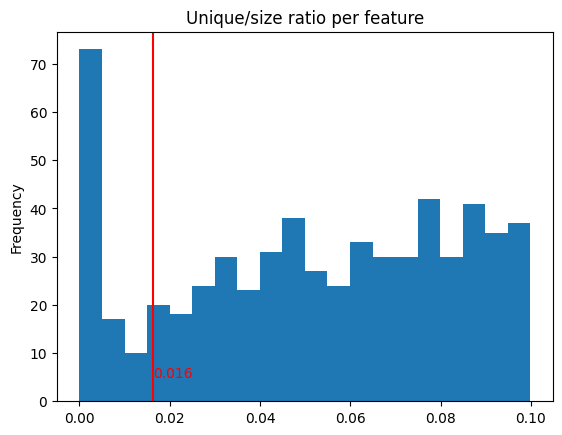

In [13]:
unique_ratio = profiles.nunique() / profiles.shape[0]
unique_ratio[unique_ratio<0.1].plot(kind="hist", bins=20, title="Unique/size ratio per feature")
plt.axvline(x=unique_ratio["Cells_Count"], color="red")
plt.text(unique_ratio["Cells_Count"], 5, f"{unique_ratio['Cells_Count']:.3f}", color="red")

#### Check other count columns

Updated preprocessing protocol will preserve count features through feature selection

In [14]:
count_cols = profiles.columns[profiles.columns.str.contains("count", case=False)]
for count_col in count_cols:
    print(f"Ratio unique/size for {count_col}: {unique_ratio[count_col]:.4f}")

Ratio unique/size for Cells_Count: 0.0163
Ratio unique/size for Cells_Children_Cytoplasm_Count: 0.0006
Ratio unique/size for Nuclei_Children_Cytoplasm_Count: 0.0006


#### List metadata stats

In [15]:
profiles.filter(regex="^Metadata_").nunique()

Metadata_JCP2022             15096
Metadata_broad_sample        15096
Metadata_Name                15096
Metadata_Vector                  1
Metadata_Transcript          13552
Metadata_Symbol              12601
Metadata_NCBI_Gene_ID        12601
Metadata_Taxon_ID                2
Metadata_Gene_Description    12451
Metadata_Prot_Match            904
Metadata_Insert_Length        1667
Metadata_pert_type               2
Metadata_Source                  1
Metadata_Plate                 225
Metadata_Well                  368
Metadata_plate_map_name         45
Metadata_Batch                  12
dtype: int64

#### List batches and plates that are missing cell counts

In [16]:
profiles[~profiles.Metadata_Plate.isin(cell_counts.Metadata_Plate)][["Metadata_Batch", "Metadata_Plate"]].groupby("Metadata_Batch").nunique()

,Metadata_Plate
Metadata_Batch,


In [17]:
profiles[profiles.Metadata_Batch == "2021_08_23_Batch12"].groupby(["Metadata_Plate"]).count().index.to_list()

[]

In [18]:
profiles = profiles[~profiles.filter(regex="^(?!Metadata_)").isnull().T.any()]

#### Save filtered profiles with metadata

In [19]:
profiles.to_parquet("output/raw_filtered_profiles.parquet", index=False)

In [20]:
profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,82.875999,76.996002,77.473999,76.582001,77.233002,78.186996,80.055000,77.632004,79.955002,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,93.607002,88.196999,89.211998,88.081001,89.154999,89.897003,92.719002,89.843002,92.597000,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,133.380005,126.150002,127.250000,125.769997,127.250000,128.429993,131.880005,127.940002,131.960007,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,84.871002,80.910004,81.814003,80.850998,81.926003,82.567001,85.179001,82.646004,85.292999,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,91.669998,87.241997,87.132004,86.538002,87.476997,88.224998,90.223000,87.663002,90.227997,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82270,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,71.441002,66.777000,67.111000,66.614998,66.950996,67.466003,69.115997,67.341003,69.023003,2021_08_30_Batch13
82271,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,76.763000,72.568001,73.039001,72.873001,73.301003,73.550003,75.428001,73.696999,75.563004,2021_08_30_Batch13
82272,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,91.638000,86.575996,87.012001,86.803001,87.361000,87.459999,89.482002,87.972000,90.033997,2021_08_30_Batch13
82273,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,47.766998,45.113998,45.214001,45.137001,45.473999,45.556000,46.622002,45.544998,46.728001,2021_08_30_Batch13


#### Make sure no metadata columns weren't matched when merging

In [22]:
# list features ending with either "_x" or "_y", case insensitive
profiles.columns[profiles.columns.str.contains("(_x|_y)$", case=False)]

/var/folders/41/1jdfcmfs0gx7qwx9d31rtxgr0000gq/T/ipykernel_31859/73147290.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  profiles.columns[profiles.columns.str.contains("(_x|_y)$", case=False)]


Index(['Cells_AreaShape_BoundingBoxMaximum_X',
       'Cells_AreaShape_BoundingBoxMaximum_Y',
       'Cells_AreaShape_BoundingBoxMinimum_X',
       'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X',
       'Cells_AreaShape_Center_Y', 'Cytoplasm_AreaShape_BoundingBoxMaximum_X',
       'Cytoplasm_AreaShape_BoundingBoxMaximum_Y',
       'Cytoplasm_AreaShape_BoundingBoxMinimum_X',
       'Cytoplasm_AreaShape_BoundingBoxMinimum_Y',
       'Cytoplasm_AreaShape_Center_X', 'Cytoplasm_AreaShape_Center_Y',
       'Nuclei_AreaShape_BoundingBoxMaximum_X',
       'Nuclei_AreaShape_BoundingBoxMaximum_Y',
       'Nuclei_AreaShape_BoundingBoxMinimum_X',
       'Nuclei_AreaShape_BoundingBoxMinimum_Y', 'Nuclei_AreaShape_Center_X',
       'Nuclei_AreaShape_Center_Y', 'Nuclei_Location_Center_X',
       'Nuclei_Location_Center_Y'],
      dtype='object')